# Introduction to the tutorials

## The Jupyter notebook

The document you are reading may be a PDF or a web page or another format, but what matters most is how it has been made ...

According to this article in [Nature](http://www.nature.com/news/interactive-notebooks-sharing-the-code-1.16261) the Notebook, invented by iPython, and now part of the Jupyter project, is the revolution for data analysis which will allow reproducable science.

This tutorial will introduce you to how to access to the notebook, how to use it and perform some basic data analysis with it and the pyFAI library.

## Getting access to the notebook:

### For ESRF staff and users
*The European Syncrotron* offers Jupyter services for data analysis to all its users. Simply connect to [Jupyter-SLURM](https://jupyter-slurm.esrf.fr) and authenticate with your ESRF credentials.
Once there, click on the *Start* button to get access to a computer via the web interface.

### Jupyter in the cloud
The [Binder-hub service](https://github.com/silx-kit/pyFAI/blob/master/README.rst) is configured in the Github repository of pyFAI. Just click on the third badge to launch the service in the cloud. Since it is free, the compute resources are limited and only the simplest tutorials are usable there.

### Other cases
In the most general case you will need to install the notebook on your local computer in addition to silx, pyFAI and FabIO to follow the tutorial. WinPython or Anaconda provides also packages for *pyFAI* and *FabIO* and *silx*.

## Getting trained in using the notebook

There are plenty of good tutorials on how to use the notebook.
[This one](https://github.com/jupyter/mozfest15-training/blob/master/00-python-intro.ipynb) presents a quick overview of the Python programming language and explains how to use the notebook. Reading it is strongly encouraged before proceeding to the pyFAI tutorials.

Anyway, the most important information is to use **Control-Enter** to evaluate a cell.

In addition to this, we will need to download some files from the internet. 
The following cell contains a piece of code to download files using the silx library. You may have to adjust the proxy settings to be able to connect to internet, especially at ESRF, see the commented out code.

## Introduction to diffraction image analysis using the notebook

All the tutorials in pyFAI are based on the notebook and if you wish to practice the exercises, you can download the notebook files (.ipynb) from [Github](https://github.com/silx-kit/pyFAI/tree/master/doc/source/usage/tutorial)

### Load and display diffraction images

First of all we will download an image and display it. Displaying it the right way is important as the orientation of the image imposes the azimuthal angle sign.

In [1]:
#Nota: May be used if you are behind a firewall and need to setup a proxy
import os
#os.environ["http_proxy"] = "http://proxy.company.fr:3128"
import time
import numpy
start_time = time.perf_counter()
import pyFAI
from pyFAI.integrator.azimuthal import AzimuthalIntegrator
print("Using pyFAI version", pyFAI.version)

Using pyFAI version 2025.1.0-dev0


In [2]:
from silx.resources import ExternalResources
downloader = ExternalResources("pyFAI", "http://www.silx.org/pub/pyFAI/testimages/", "DATA")
#remove result files to avoid warnings
for res in ("moke.dat",):
    if os.path.exists(res):
        os.unlink(res)

In [3]:
moke = downloader.getfile("moke.tif")
print(moke)

/tmp/pyFAI_testdata_kieffer/moke.tif


The *moke.tif* image we just downloaded is not a real diffraction image but it is a test pattern used in the tests of pyFAI. 

Prior to displaying it, we will use the Fable Input/Output library to read the content of the file:

In [4]:
#initializes the visualization module to work with the jupyter notebook
%matplotlib inline
#Better user experience can be obtained with
# %matplotlib widget
from matplotlib.pyplot import subplots

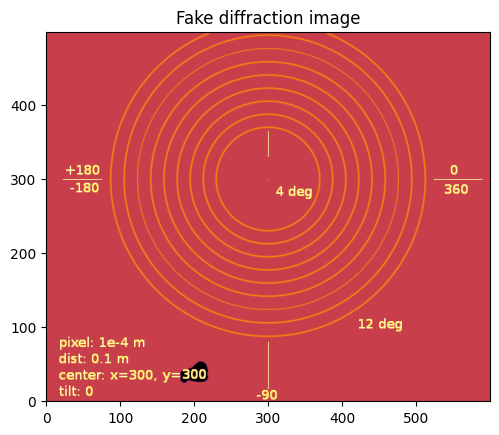

In [5]:
import fabio
from pyFAI.gui import jupyter
img = fabio.open(moke).data
jupyter.display(img, label ="Fake diffraction image")
pass

As you can see, the image looks like an archery target. The origin is at the **lower left** of the image. 
If you are familiar with matplotlib, it correspond to the option *origin="lower"* of *imshow*.

Displaying the image using imsho without this option ends with having the azimuthal angle (which angles are displayed in degrees on the image) to turn clockwise, so the inverse of the trigonometric order:

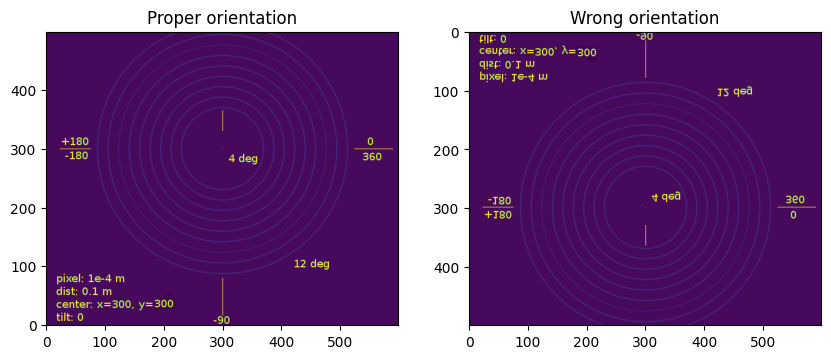

In [6]:
fig, ax = subplots(1,2, figsize=(10,5))
ax[0].imshow(img, origin="lower")
ax[0].set_title("Proper orientation")
ax[1].imshow(img)
ax[1].set_title("Wrong orientation")
pass

**Nota:** Displaying the image properly or not does not change the content of the image nor its representation in memory, it only changes its representation, which is important only for the user. **DO NOT USE** *numpy.flipud* or other array-manipulation which changes the memory representation of the image. This is likely to mess-up all your subsequent  calculation.

### 1D azimuthal integration

To perform an azimuthal integration of this image, we need to create an **AzimuthalIntegrator** object we will call *ai*. 
Fortunately, the geometry is explained on the image.

In [7]:
import pyFAI, pyFAI.detectors
detector = pyFAI.detectors.Detector(pixel1=1e-4, pixel2=1e-4)
ai = AzimuthalIntegrator(dist=0.1, detector=detector)
# Short version ai = pyFAI.AzimuthalIntegrator(dist=0.1, pixel1=1e-4, pixel2=1e-4)
print(ai)

Detector Detector	 PixelSize= 100µm, 100µm	 BottomRight (3)
SampleDetDist= 1.000000e-01 m	PONI= 0.000000e+00, 0.000000e+00 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=0.000, y=0.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000°


Printing the *ai* object displays 3 lines:

 * The detector definition, here a simple detector with square, regular pixels with the right size
 * The detector position in space using the *pyFAI* coordinate system: dist, poni1, poni2, rot1, rot2, rot3
 * The detector position in space using the *FIT2D* coordinate system: direct_sample_detector_distance, center_X,
center_Y, tilt and tilt_plan_rotation

Right now, the geometry in the *ai* object is wrong. It may be easier to define it correctly using the *FIT2D* geometry which uses pixels for the center coordinates (but the sample-detector distance is in millimeters).

In [8]:
help(ai.setFit2D)

Help on method setFit2D in module pyFAI.geometry.core:

setFit2D(directDist, centerX, centerY, tilt=0.0, tiltPlanRotation=0.0, pixelX=None, pixelY=None, splineFile=None, detector=None, wavelength=None) method of pyFAI.integrator.azimuthal.AzimuthalIntegrator instance
    Set the Fit2D-like parameter set: For geometry description see
    HPR 1996 (14) pp-240
    https://doi.org/10.1080/08957959608201408
    
    By reverse engineering we noticed this behavour for Tiff and Mar345 images (at least).
    To obtaine correct result you will have to flip images using numpy.flipud.
    
    :param direct: direct distance from sample to detector along the incident beam (in millimeter as in fit2d)
    :param tilt: tilt in degrees
    :param tiltPlanRotation: Rotation (in degrees) of the tilt plan arround the Z-detector axis
            * 0deg -> Y does not move, +X goes to Z<0
            * 90deg -> X does not move, +Y goes to Z<0
            * 180deg -> Y does not move, +X goes to Z>0
         

In [9]:
ai.setFit2D(100, 300, 300)
print(ai)

Detector Detector	 PixelSize= 100µm, 100µm	 BottomRight (3)
SampleDetDist= 1.000000e-01 m	PONI= 3.000000e-02, 3.000000e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=300.000, y=300.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000°


With the *ai* object properly setup, we can perform the azimuthal integration using the *intergate1d* method.
This methods takes only 2 mandatory parameters: the image to integrate and the number of bins. We will provide a few other to enforce the calculations to be performed in 2theta-space and in degrees:

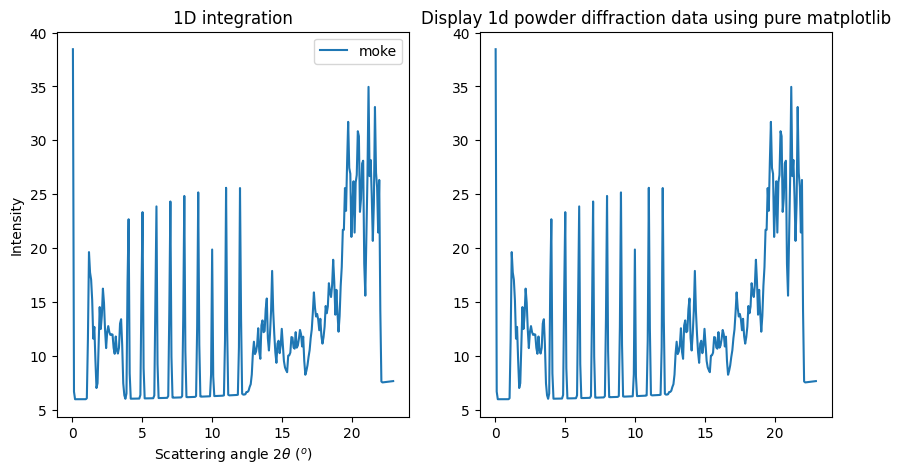

In [10]:
res = ai.integrate1d(img, 300, unit="2th_deg")

#Display the integration result 
fig, ax = subplots(1,2, figsize=(10,5))
jupyter.plot1d(res, label="moke",ax=ax[0])

#Example using pure matplotlib
tth = res[0]
I = res[1]
ax[1].plot(tth, I, label="moke")
ax[1].set_title("Display 1d powder diffraction data using pure matplotlib")
pass

As you can see, the 9 rings gave 9 sharp peaks at 2theta position regularly ranging from 4 to 12 degrees as expected from the image annotation.

**Nota:** the default radial unit is "q_nm^1", so the scattering vector length expressed in inverse nanometers. To be able to calculate *q*, one needs to specify the wavelength used (here we didn't). For example: ai.wavelength = 1e-10 

To save the content of the integrated pattern into a 2 column ASCII file, one can either save the (tth, I) arrays, or directly ask pyFAI to do it by providing an output filename:

In [11]:
ai.integrate1d(img, 30, unit="2th_deg", filename="moke.dat")

# now display the content of the file
with open("moke.dat") as fd:
    for line in fd:
        print(line.strip())

# {
#     "poni_version": 2.1,
#     "detector": "Detector",
#     "detector_config": {
#         "pixel1": 0.0001,
#         "pixel2": 0.0001,
#         "max_shape": null,
#         "orientation": 3
#     },
#     "dist": 0.1,
#     "poni1": 0.030000000000000002,
#     "poni2": 0.030000000000000002,
#     "rot1": 0.0,
#     "rot2": 0.0,
#     "rot3": 0
# }
# Mask applied: False
# Dark current applied: False
# Flat field applied: False
# Polarization factor: None
# Normalization factor: 1.0
# --> moke.dat
#       2th_deg             I
3.831631e-01    6.384649e+00
1.149489e+00    1.240585e+01
1.915815e+00    1.222192e+01
2.682142e+00    1.170374e+01
3.448468e+00    9.966028e+00
4.214794e+00    8.916004e+00
4.981120e+00    9.104006e+00
5.747446e+00    9.238893e+00
6.513773e+00    6.136210e+00
7.280099e+00    9.044517e+00
8.046425e+00    9.204640e+00
8.812751e+00    9.319985e+00
9.579077e+00    6.469373e+00
1.034540e+01    7.795617e+00
1.111173e+01    9.413619e+00
1.187806e+01    9.460720

This "moke.dat" file contains in addition to the 2th/I value, a header commented with "#" with the geometry used to perform the calculation.

**Nota: ** The *ai* object has initialized the geometry on the first call and re-uses it on subsequent calls. This is why it is important to re-use the geometry in performance critical applications.

### 2D integration or Caking

One can perform the 2D integration which is called caking in FIT2D by simply calling the *intrgate2d* method with 3 mandatroy parameters: the data to integrate, the number of radial bins and the number of azimuthal bins.  

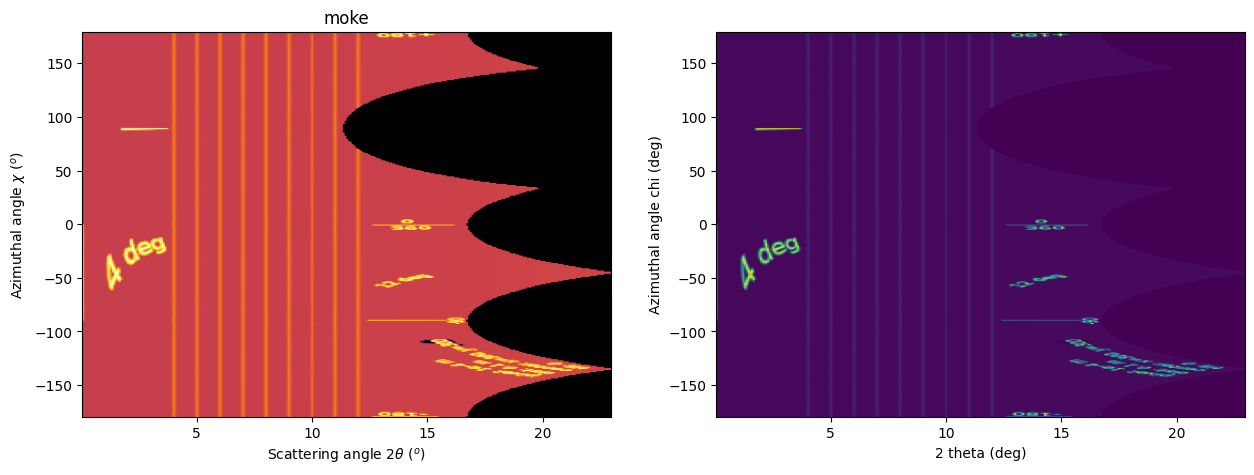

In [12]:
res2d = ai.integrate2d(img, 300, 360, unit="2th_deg")

#Display the integration result 
fig, ax = subplots(1,2, figsize=(15,5))
jupyter.plot2d(res2d, label="moke",ax=ax[0])

#Example using pure matplotlib
I, tth, chi = res2d
ax[1].imshow(I, origin="lower", extent=[tth.min(), tth.max(), chi.min(), chi.max()], aspect="auto")
ax[1].set_xlabel("2 theta (deg)")
ax[1].set_ylabel("Azimuthal angle chi (deg)")
pass

The displayed images the "caked" image with the radial and azimuthal angles properly set on the axes. Search for the -180, -90, 360/0 and 180 mark on the transformed image.

Like *integrate1d*, *integrate2d* offers the ability to save the intgrated image into an image file (EDF format by default) with again all metadata in the headers. 

### Radial integration

Radial integration can directly be obtained from Caked images:  

Column number 34


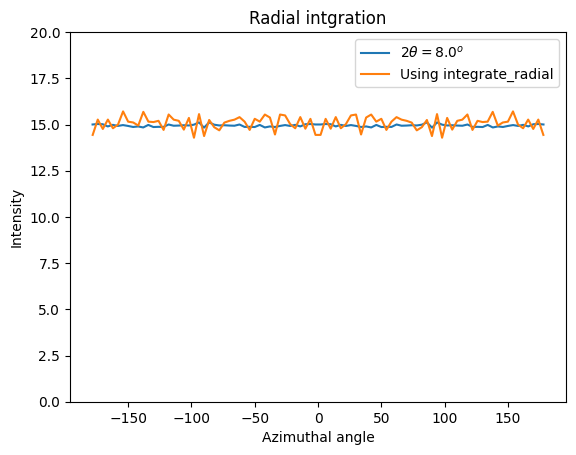

In [13]:
target = 8 #degrees
#work on fewer radial bins in order to have an actual averaging:
I, tth, chi = ai.integrate2d_ng(img, 100, 90, unit="2th_deg")
column = numpy.argmin(abs(tth-target))
print("Column number %s"%column)

fig, ax = subplots()
ax.plot(chi, I[:,column], label=r"$2\theta=%.1f^{o}$"%target)
ax.set_xlabel("Azimuthal angle")
ax.set_ylabel("Intensity")
ax.set_ylim(0, 20)
ax.set_title("Radial intgration")
ax.plot(*ai.integrate_radial(img, 90, radial_range=(7.87, 8.13), radial_unit="2th_deg", 
                             method=("no", "histogram", "cython")), 
        label="Using integrate_radial")
ax.legend()
pass

**Nota:** the pattern with higher noise along the diagonals is typical from the pixel splitting scheme employed. Here this scheme is a "bounding box" which makes digonal pixels look a bit larger (+40%) than the ones on the horizontal and vertical axis, explaining the variation of the noise.

### Integration of a bunch of files using pyFAI

Once the processing for one file is established, one can loop over a bunch of files.
A convienient way to get the list of files matching a pattern is with the *glob* module.

Most of the time, the azimuthal integrator is obtained by simply loading the *poni-file* into pyFAI and use it directly. 


In [14]:
all_files = downloader.getdir("alumina.tar.bz2")
all_edf = [i for i in all_files if i.endswith("edf")]
all_edf.sort()
print("Number of EDF downloaded: %s"%len(all_edf))

Number of EDF downloaded: 52


In [15]:
ponifile = [i for i in all_files if i.endswith(".poni")][0]
splinefile = [i for i in all_files if i.endswith(".spline")][0]
print(ponifile, splinefile)

#patch the poni-file with the proper path.
with open(ponifile, "a") as f:
    f.write("SplineFile: %s\n"%splinefile)

ai = pyFAI.load(ponifile)
print(ai)

/tmp/pyFAI_testdata_kieffer/alumina.tar.bz2__content/alumina/al2o3_00_max_51_frames.poni /tmp/pyFAI_testdata_kieffer/alumina.tar.bz2__content/alumina/distorsion_2x2.spline
Detector Detector	 Spline= /tmp/pyFAI_testdata_kieffer/alumina.tar.bz2__content/alumina/distorsion_2x2.spline	 PixelSize= 103.358µm, 102.53µm	 BottomRight (3)
Wavelength= 7.084811e-11 m
SampleDetDist= 1.168599e-01 m	PONI= 5.295653e-02, 5.473342e-02 m	rot1=0.015821  rot2=0.009404  rot3=0.000000 rad
DirectBeamDist= 116.880 mm	Center: x=515.795, y=522.995 pix	Tilt= 1.055° tiltPlanRotation= 149.271° 𝛌= 0.708Å


Integration time for al2o3_0000.dat: 0.377 s
Integration time for al2o3_0001.dat: 0.022 s
Integration time for al2o3_0002.dat: 0.022 s
Integration time for al2o3_0003.dat: 0.022 s
Integration time for al2o3_0004.dat: 0.021 s
Integration time for al2o3_0005.dat: 0.021 s
Integration time for al2o3_0006.dat: 0.021 s
Integration time for al2o3_0007.dat: 0.022 s
Integration time for al2o3_0008.dat: 0.018 s
Integration time for al2o3_0009.dat: 0.021 s
Integration time for al2o3_0010.dat: 0.022 s
Integration time for al2o3_0011.dat: 0.021 s
Integration time for al2o3_0012.dat: 0.022 s
Integration time for al2o3_0013.dat: 0.021 s
Integration time for al2o3_0014.dat: 0.021 s
Integration time for al2o3_0015.dat: 0.021 s
Integration time for al2o3_0016.dat: 0.021 s
Integration time for al2o3_0017.dat: 0.021 s
Integration time for al2o3_0018.dat: 0.022 s
Integration time for al2o3_0019.dat: 0.021 s
Integration time for al2o3_0020.dat: 0.021 s
Integration time for al2o3_0021.dat: 0.022 s
Integratio

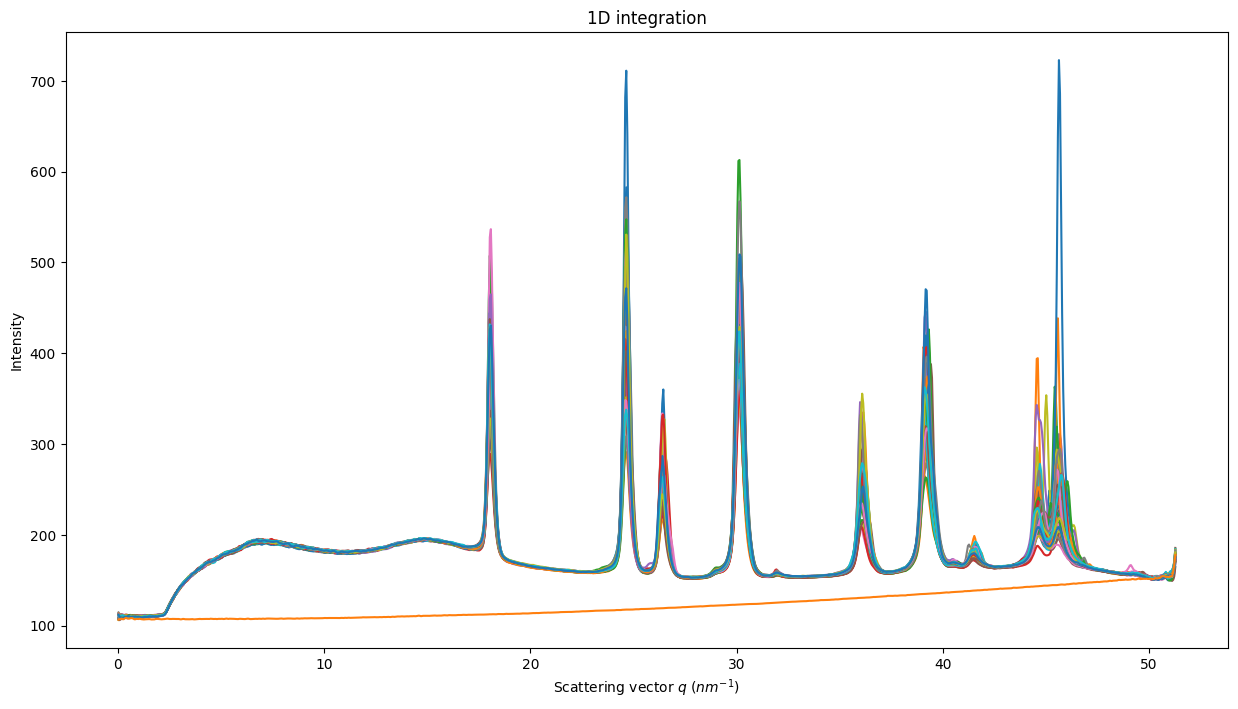

In [16]:
fig, ax = subplots(figsize=(15,8))

for one_file in all_edf:
    destination = os.path.splitext(one_file)[0]+".dat"
    if os.path.exists(destination):
        os.unlink(destination)
    image = fabio.open(one_file).data
    t0 = time.perf_counter()
    res = ai.integrate1d(image, 1000, filename=destination)
    print(f"Integration time for {os.path.basename(destination)}: {time.perf_counter()-t0:.3f} s")
    jupyter.plot1d(res, ax=ax)
pass

This was a simple integration of 50 files, saving the result into 2 column ASCII files.

**Nota:** the first frame took 40x longer than the other. This highlights go crucial it is to re-use *azimuthal intgrator* objects when performance matters.

## Conclusion
Using the notebook is rather simple as it allows to mix comments, code, and images for visualization of scientific data.

The basic use pyFAI's AzimuthalIntgrator has also been presented and may be adapted to you specific needs.

In [17]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f} s")

Total execution time: 6.717 s
